Epoch 01 - Distillation Loss: 0.3858
Epoch 02 - Distillation Loss: 0.3841
Epoch 03 - Distillation Loss: 0.3824
Epoch 04 - Distillation Loss: 0.3808
Epoch 05 - Distillation Loss: 0.3791
Epoch 06 - Distillation Loss: 0.3774
Epoch 07 - Distillation Loss: 0.3757
Epoch 08 - Distillation Loss: 0.3741
Epoch 09 - Distillation Loss: 0.3724
Epoch 10 - Distillation Loss: 0.3708
Epoch 11 - Distillation Loss: 0.3692
Epoch 12 - Distillation Loss: 0.3676
Epoch 13 - Distillation Loss: 0.3660
Epoch 14 - Distillation Loss: 0.3644
Epoch 15 - Distillation Loss: 0.3628
Epoch 16 - Distillation Loss: 0.3613
Epoch 17 - Distillation Loss: 0.3597
Epoch 18 - Distillation Loss: 0.3582
Epoch 19 - Distillation Loss: 0.3567
Epoch 20 - Distillation Loss: 0.3552
Epoch 21 - Distillation Loss: 0.3537
Epoch 22 - Distillation Loss: 0.3523
Epoch 23 - Distillation Loss: 0.3508
Epoch 24 - Distillation Loss: 0.3494
Epoch 25 - Distillation Loss: 0.3480
Epoch 26 - Distillation Loss: 0.3466
Epoch 27 - Distillation Loss: 0.3452
E

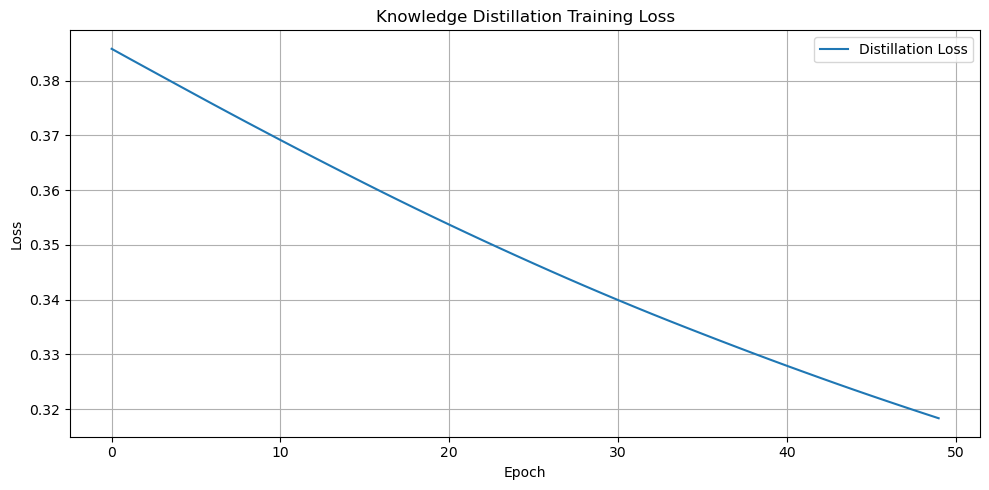

In [2]:

# 와인데이터 세트를 활용한 KD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from scipy.special import softmax

# 1. 데이터 로딩 및 전처리
data = load_wine()
X = StandardScaler().fit_transform(data.data)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Teacher 모델 훈련 (복잡하고 무거운 모델)
teacher = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
teacher.fit(X_train, y_train)

# 3. Student 모델 정의 (경량화 모델)
student = MLPClassifier(hidden_layer_sizes=(16,), max_iter=1, warm_start=True, random_state=42)

# 4. 지식 증류 손실 함수
def kl_divergence(p, q):
    return np.sum(p * (np.log(p + 1e-10) - np.log(q + 1e-10)), axis=1).mean()

def distillation_loss(student_logits, teacher_logits, true_labels, temperature=2.0, alpha=0.7):
    teacher_soft = softmax(teacher_logits / temperature, axis=1)
    student_soft = softmax(student_logits / temperature, axis=1)
    kd_loss = kl_divergence(teacher_soft, student_soft) * (temperature ** 2)
    ce_loss = -np.log(student_soft[range(len(true_labels)), true_labels] + 1e-10).mean()
    return alpha * kd_loss + (1 - alpha) * ce_loss

# 5. Student 훈련
losses = []
for epoch in range(50):
    student.partial_fit(X_train, y_train, classes=np.unique(y_train))
    teacher_logits = teacher.predict_proba(X_train)
    student_logits = student.predict_proba(X_train)
    
    loss = distillation_loss(student_logits, teacher_logits, y_train)
    losses.append(loss)
    print(f"Epoch {epoch + 1:02d} - Distillation Loss: {loss:.4f}")

# 6. 평가
y_pred_teacher = teacher.predict(X_test)
y_pred_student = student.predict(X_test)

teacher_acc = accuracy_score(y_test, y_pred_teacher)
student_acc = accuracy_score(y_test, y_pred_student)

print("\n=== 최종 정확도 ===")
print(f"Teacher 모델 정확도: {teacher_acc * 100:.2f}%")
print(f"Student 모델 정확도: {student_acc * 100:.2f}%")

# 7. 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Knowledge Distillation Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
